# Lab 2: Classification

### Machine Learning 1, September 2016

* The lab exercises should be made in groups of two people.
* The deadline is October 9th (Sunday) 23:59.
* Assignment should be sent to your teaching assistant. The subject line of your email should be "lab\#\_lastname1\_lastname2\_lastname3".
* Put your and your teammates' names in the body of the email.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "lab01\_Kingma\_Hu", the attached file should be "lab01\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* For this notebook you need to answer a few theory questions, add them in the Markdown cell's below the question. Note: you can use Latex-style code in here.
* Focus on Part 1 the first week, and Part 2 the second week!
* You should write your code and answers below the questions in this IPython Notebook.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* If you have questions outside of the labs, post them on blackboard or email me.
* NOTE: Make sure we can run your notebook / scripts!

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [3]:
%pylab inline
import gzip, cPickle, time

Populating the interactive namespace from numpy and matplotlib


# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can load the data from `mnist.pkl.gz` we provided, using: 

In [4]:
def load_mnist():
    f = gzip.open('mnist.pkl.gz', 'rb')
    data = cPickle.load(f)
    f.close()
    return data

(x_train, t_train), (x_valid, t_valid), (x_test, t_test) = load_mnist()

The tuples represent train, validation and test sets. The first element (`x_train`, `x_valid`, `x_test`) of each tuple is a $N \times M$ matrix, where $N$ is the number of datapoints and $M = 28^2 = 784$ is the dimensionality of the data. The second element (`t_train`, `t_valid`, `t_test`) of each tuple is the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

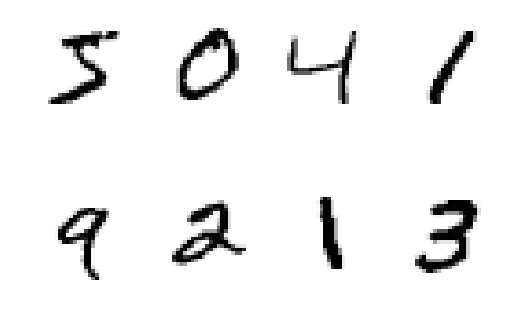

In [5]:
def plot_digits(data, numcols, shape=(28,28)):
    numdigits = data.shape[0]
    numrows = int(numdigits/numcols)
    for i in range(numdigits):
        plt.subplot(numrows, numcols, i+1)
        plt.axis('off')
        plt.imshow(data[i].reshape(shape), interpolation='nearest', cmap='Greys')
    plt.show()
    
plot_digits(x_train[0:8], numcols=4)
#print(x_train[0]) 

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_j \exp(\log q_j)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

Warning: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization

### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\dfrac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$
\delta^q_j
= \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log p_j}
\dfrac{\partial \log p_j}{\partial \log q_j}
+ \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\dfrac{\partial \log Z}{\partial Z} 
\dfrac{\partial Z}{\partial \log q_j} 
= 1 \cdot 1 - \dfrac{\partial \log Z}{\partial Z} 
\dfrac{\partial Z}{\partial \log q_j}
= 1 - \dfrac{\partial \log Z}{\partial Z} 
\dfrac{\partial Z}{\partial \log q_j}
$

For $j \neq t^{(n)}$:
$
\delta^q_j
= \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\dfrac{\partial \log Z}{\partial Z} 
\dfrac{\partial Z}{\partial \log q_j} 
= - \dfrac{\partial \log Z}{\partial Z} 
\dfrac{\partial Z}{\partial \log q_j}
$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\dfrac{\partial \log Z}{\partial Z}$ and $\dfrac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\dfrac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\dfrac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\dfrac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\dfrac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\dfrac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\dfrac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\dfrac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\dfrac{\partial \log q_j}{\partial W_{ij}}
$

What is $\dfrac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

##### Answer: 

$$\begin{equation*}
    \begin{split}
        \dfrac{\partial \log Z}{\partial Z} &= \dfrac{1}{Z} \\
        \dfrac{\partial Z}{\partial \log q_j} & = \dfrac{\partial \sum_j \exp(\log q_j)}{\partial \log q_j} = q_j \\ 
        \mathbf{\delta}^q_j &= \left ( \mathbb{I}_{t^{(n)}j} - \dfrac{q_j}{Z} \right )\\\\
        \dfrac{\partial \log q_j}{\partial W_{j}} =  \dfrac{\partial \log q_j}{\partial q_{j}} \cdot  \dfrac{\partial q_j}{\partial W_{j}} &= \dfrac{1}{q_j} \cdot q_j \cdot \bx = \bx \\
        \nabla_{\bW_j} \mathcal{L}^{(n)} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial W_{j}} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log q_{j}} \cdot \dfrac{\partial \log q_{j}}{\partial W_{j}} &= \mathbf{\delta}_{j}^q \cdot \dfrac{\partial \log q_j}{\partial W_{j}}  \\ &= \bx \cdot \left (\mathbb{I}_{t^{(n)}j} - \dfrac{q_j}{Z^{(n)}} \right)^T  \\
        \end{split}
\end{equation*}$$

### 1.1.2 Implement gradient computations (10 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

In [12]:
def logreg_gradient(x,t,W,b):
    if x.ndim == 1:
        x = np.reshape(x,[x.shape[0],1])
    
    q = np.exp(W.T.dot(x) + b)
    Z = np.sum(q)
        
    # Sanity check: check for +/- INF or NAN elements
    if np.logical_or(np.isnan(q),np.isinf(q)).any():
        print q
        raise ValueError('q_j has NAN or INF')
    
    if np.logical_or(np.isnan(Z),np.isinf(Z)).any():
        print Z
        raise ValueError('Z is NAN or INF')
    
    # delta^q_j: d L(n) / d log q_j
    delta_q = t - (q/Z)
    
    grad_W = x.dot(delta_q.T)  # dim: 784 x 10
    grad_b = delta_q # dim: 10x1   

    return grad_W, grad_b

# initialization
M = len(x_train[0])
W = np.ones((M,10))
x = x_train[0]
b = np.ones([10,1])

t = np.zeros([10,1]) #One-of-K encoding
t[t_train[0]]=1
w_g, b_g = logreg_gradient(x,t,W,b)
print w_g, b_g

(10, 1)
(10, 1)
(10, 1)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] [[-0.1]
 [-0.1]
 [-0.1]
 [-0.1]
 [-0.1]
 [ 0.9]
 [-0.1]
 [-0.1]
 [-0.1]
 [-0.1]]



### 1.1.3 Stochastic gradient descent (10 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters using a small learning rate (e.g. `1E-4`). Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [9]:
def sgd_iter(x_train, t_train, W, b, alpha=1E-4):
    
    for n in range(x_train.shape[0]):
        
        # reshape to make numpy calculations easier
        x = x_train[n,:].reshape([784,1])
        
        # Calculate gradients wrt W & b
        grad_W, grad_b = logreg_gradient(x, t_train[n,:], W, b)
        
        # Gradient ascent step
        W = W + alpha * grad_W
        b = b + alpha * grad_b
    
    return W, b

## 1.2. Train

### 1.2.1 Train (10 points)
Perform a handful of training iterations through the trainingset. Plot (in one graph) the conditional log-probability of the trainingset and validation set after each iteration.


In [10]:
# Takes the softmax of each element of the vector
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

# Computes the log of the sum of exponential functions
# Uses the Log-Sum-Exp trick
def log_sum_exp(x):
    max_val = x[np.argmax(x)]
    return max_val + np.log(np.sum(np.exp(x-max_val)))

# Computes the log probability of a model W,b given dataset matrices X and T
def log_prob(X,W,b,T):
    
    #Log_q for each row n in X: w_j^T dot x_n + b_j
    log_q = X.dot(W) + b.T 
    
    # Computes log_pn = log_qn - log_Zn for each row n in Log_q (each n in X)
    log_p = np.array([lqn - log_sum_exp(lqn) for lqn in log_q])
    
    # Computes Log_p_tn: for each n in X, computes the log probability of it label T_n: log p(t=t^(n)|x,W,b)
    log_pj = np.array([log_p[i,T[i]] for i in range(len(T))])
    
    # Sum over all N to obtain Log likelihood of entire dataset
    return log_pj.sum()
    
# Returns a binary vector of size 10x1 with one-of-K encoding
def dummy_encoding(t):
    a = np.zeros(10)
    a[t] = 1
    return a

# decodes a binary one-of-K encoded vector and returns the active index
def dummy_decoding(t):
    return np.asscalar(np.where(t>0)[0])

# Trains a logistic regression model given dataset (X,T) using Stochastic Gradient Ascent 
# Maximum iterations defined by max_iter
# Returns the model (W,b) and log probability of training and validation sets during each iteration
def train_model(X, T, X_val, T_val, max_iter, alpha=1E-4):
    
    # Initialization
    t_hot = np.array([dummy_encoding(z) for z in T]) # dummy encoding
    
    W = np.ones([784,10])
    b = np.ones([10,1])
    
    lp_tr = np.zeros(max_iter) # keep track for each iteration
    lp_val = np.zeros(max_iter)
    
    # main loop
    for i in range(max_iter):
        
        W, b = sgd_iter(X, t_hot, W, b)
        
        lp_tr[i] = log_prob(X, W, b, T) # Training set Log p
        lp_val[i]= log_prob(X_val, W, b, T_val) # Validation set Lop p
        
        print 'iter#%d, Log-p Training: %f, Valid: %f' % (i+1,lp_tr[i],lp_val[i])
    
    return W, b, lp_tr, lp_val
    

max_iter = 20
W_optima, b_optima, lp_tr, lp_val = train_model(x_train[:,:], t_train[:], x_valid[:,:], t_valid[:], max_iter)


iter#1, Log-p Training: -40518.120876, Valid: -7631.571874
iter#2, Log-p Training: -30976.232398, Valid: -5707.951086
iter#3, Log-p Training: -27077.592701, Valid: -4946.670873
iter#4, Log-p Training: -24868.219103, Valid: -4526.297576
iter#5, Log-p Training: -23409.509423, Valid: -4254.687735
iter#6, Log-p Training: -22356.902342, Valid: -4062.275549
iter#7, Log-p Training: -21551.921860, Valid: -3917.456853
iter#8, Log-p Training: -20910.638364, Valid: -3803.681933
iter#9, Log-p Training: -20384.060563, Valid: -3711.392558
iter#10, Log-p Training: -19941.476343, Valid: -3634.657248
iter#11, Log-p Training: -19562.551510, Valid: -3569.586849
iter#12, Log-p Training: -19233.228586, Valid: -3513.517675
iter#13, Log-p Training: -18943.442777, Valid: -3464.559549
iter#14, Log-p Training: -18685.775932, Valid: -3421.331141
iter#15, Log-p Training: -18454.625524, Valid: -3382.797607
iter#16, Log-p Training: -18245.671250, Valid: -3348.167021
iter#17, Log-p Training: -18055.521135, Valid: -3

[]

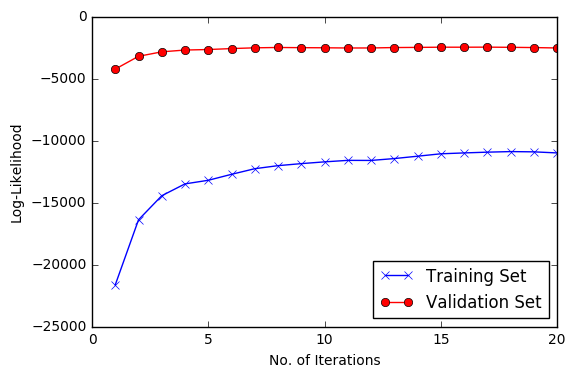

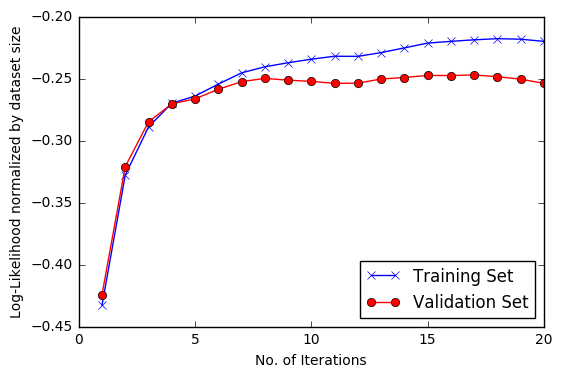

In [19]:
fig = plt.figure()
plt.plot(range(1,max_iter+1),lp_tr,'bx-')
plt.plot(range(1,max_iter+1),lp_val,'ro-')
plt.legend(['Training Set', 'Validation Set'],loc='lower right')
plt.xlabel('No. of Iterations')
plt.ylabel('Log-Likelihood')
plt.plot()

# Normalize by dataset size

fig = plt.figure()
plt.plot(range(1,max_iter+1),lp_tr/x_train.shape[0],'bx-')
plt.plot(range(1,max_iter+1),lp_val/x_valid.shape[0],'ro-')
plt.legend(['Training Set', 'Validation Set'],loc='lower right')
plt.xlabel('No. of Iterations')
plt.ylabel('Log-Likelihood normalized by dataset size')
plt.plot()


### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.

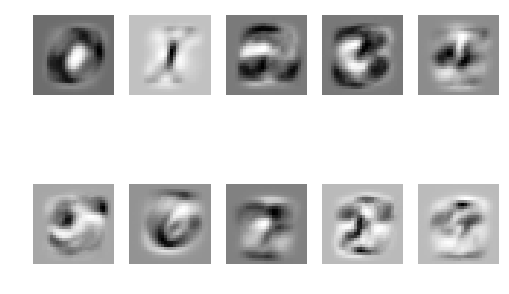

In [12]:
def plot_digits(data, numcols, shape=(28,28)):
    numdigits = data.shape[0]
    numrows = int(numdigits/numcols)
    for i in range(numdigits):
        plt.subplot(numrows, numcols, i+1)
        plt.axis('off')
        plt.imshow(data[i].reshape(shape), interpolation='nearest', cmap='Greys')
    plt.show()
    
max_iter = 20
# W_optima, b_optima, lp_tr, lp_val = train_model(x_train[:,:], t_train[:], x_valid[:,:], t_valid[:], max_iter)
plot_digits(W_optima.T, numcols=5)

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.
Ask yourself if these results make sense.

(20,)
Best 8
[-2471.36536124 -2475.23486056 -2476.23098446 -2485.21329636 -2492.03554166
 -2499.08888748 -2504.13201635 -2505.42989066]


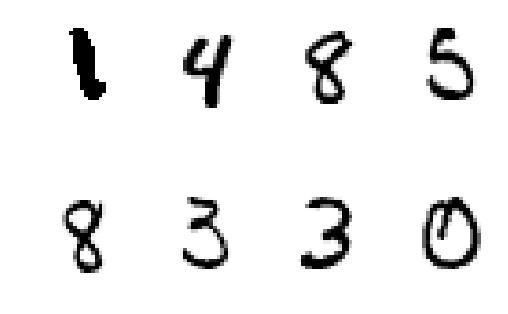

Worst 8
[-2538.82357447 -2539.17172962 -2587.01493307 -2664.03466874 -2704.86302652
 -2849.92257853 -3210.45325556 -4243.66890649]


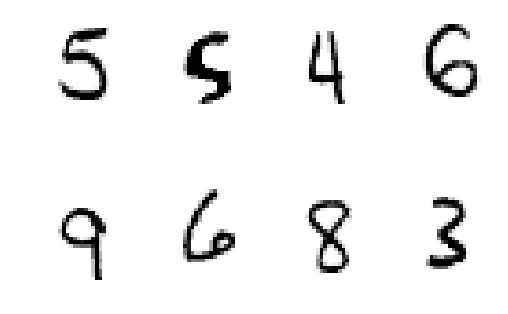

In [27]:
print lp_val.shape
sorted_idx = np.argsort(-lp_val) # inverted as its log-p
best_8 = x_valid[sorted_idx[:8]]
worst_8 = x_valid[sorted_idx[-8:]]

print 'Best 8'
print lp_val[sorted_idx[:8]]
plot_digits(best_8, numcols=4)

print 'Worst 8'
print lp_val[sorted_idx[-8:]]
plot_digits(worst_8, numcols=4)

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron wil have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$.

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

##### Answer: 

$\nabla_{\bb} \mathcal{L}^{(n)}$ is initialized in the hidden layer $\bh$ and is not influenced by the input layer. Therefore, the hidden layer to the output later independently can be viewed as multi-class logistic regression. Similarly, we can view $\nabla_{\bw_j} \mathcal{L}^{(n)}$ as a multi-class logistic regression where the input variable is $\bh$ instead of $\bx$. This accounts for the small difference between the formulations for $\nabla_{\bw_j} \mathcal{L}^{(n)}$ in the multi-class logistic regression and a 1-layer neural network.

## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

##### Answer: 

By introducing a Gaussian prior on parameters W,V,b and a, we can maximize the posterior distribution on the model parameters by maximizing the product of the likelihood and prior (Bayesian learning). The MAP estimators for each parameter will have a different form than our MLE estimators. In essence wes will penalize the model according to our priors and reduce overfitting which is very common with Neural Networks. Note that we will be penalizing the parameters and the bias nodes independently, which is a good method as the bias terms a and b (intercepts) are not subject to the same variance as V or W.

## 2.3. Implement and train a MLP (15 points)

Implement a MLP model with a single hidden layer, and code to train the model.

In [13]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

# Computes the log of the sum of exponential functions
# Uses the Log-Sum-Exp trick
def log_sum_exp(x):
    max_val = x[np.argmax(x)]
    return max_val + np.log(np.sum(np.exp(x-max_val)))


# Returns a binary vector of size 10x1 with one-of-K encoding
def dummy_encoding(t):
    a = np.zeros(10)
    a[t] = 1
    return a

# decodes a binary one-of-K encoded vector and returns the active index
def dummy_decoding(t):
    return np.asscalar(np.where(t>0)[0])

def sigmoid(X):
    return np.array(1/(1+np.exp(-X)))

# Computes the log probability of a model W,b given dataset matrices X and T
def log_prob_mlp(X,T,V,W,a,b):
    
    # Input to hidden layer
    H = sigmoid(X.dot(V) + a.T)
    
    #Log_q for each row n in X: w_j^T dot x_n + b_j
    log_q = H.dot(W) + b.T 
    
    # Computes log_pn = log_qn - log_Zn for each row n in Log_q (each n in X)
    log_p = np.array([lqn - log_sum_exp(lqn) for lqn in log_q])
    
    # Computes Log_p_tn: for each n in X, computes the log probability of it label T_n: log p(t=t^(n)|x,W,b)
    log_pj = np.array([log_p[i,T[i]] for i in range(len(T))])
    
    # Sum over all N to obtain Log likelihood of entire dataset
    return log_pj.sum()

# Computes gradients of model parameters
def mlp_gradient(x,t,V,W,a,b):
    if x.ndim == 1:
        x = np.reshape(x,[x.shape[0],1])
    
    # output of hidden layer
    h = sigmoid(V.T.dot(x) + a)
    
    # output of network
    q = np.exp(W.T.dot(h) + b)
    Z = np.sum(q)            
    
    # Sanity check: check for +/- INF or NAN elements
    if np.logical_or(np.isnan(q),np.isinf(q)).any():
        print q
        raise ValueError('q_j has NAN or INF')
    if np.logical_or(np.isnan(Z),np.isinf(Z)).any():
        print Z
        raise ValueError('Z is NAN or INF')
    if np.logical_or(np.isnan(h),np.isinf(h)).any():
        print q
        raise ValueError('h_j has NAN or INF')
    
    # delta^q_j: d L(n) / d log q_j
    t_n = np.asscalar(np.where(t>0)[0])
    
    delta_q = np.reshape([(j==t_n) - q[j]/Z for j in range(len(q))],[10,1]) # dim: 10 x 1
    delta_h = W.dot(delta_q) # dim: L x 1
    grad_a = delta_h.dot(h.T.dot(1-h)) # dim: L x 1
    grad_V = x.dot(grad_a.T) # dim
    grad_W = h.dot(delta_q.T)  # dim: L x 10
    grad_b = delta_q # dim: 10x1

    return grad_V, grad_W, grad_a, grad_b


def sgd_iter_mlp(x_train, t_train, V, W, a, b, alpha=1E-4):
    
    for n in range(x_train.shape[0]):
        
        # reshape to make numpy calculations easier
        x = x_train[n,:].reshape([784,1])
        t = t_train[n,:]
        
        # Calculate gradients wrt W & b
        grad_V, grad_W, grad_a, grad_b = mlp_gradient(x,t,V,W,a,b)
        
#         print grad_V.sum()
#         print grad_W.sum()
#         print grad_a.sum()
#         print grad_b.sum()
        
        # Gradient ascent step
        W = W + alpha * grad_W
        b = b + alpha * grad_b
        V = V + alpha * grad_V
        a = a + alpha * grad_a
        
    return V, W, a, b

# Trains a logistic regression model given dataset (X,T) using Stochastic Gradient Ascent 
# Maximum iterations defined by max_iter
# Returns the model (W,b) and log probability of training and validation sets during each iteration
def train_model_mlp(X, T, X_val, T_val, max_iter, L, alpha=1E-4):
    
    # Initialization
    t_hot = np.array([dummy_encoding(z) for z in T]) # dummy encoding
    
    mu, sigma = 0, 1
    W = np.random.normal(mu,sigma,[L,10])
    b = np.random.rand(10,1)
    V = np.random.normal(mu,sigma,[784,L])
    a = np.random.rand(L,1)
    
    lp_tr = np.zeros(max_iter) # keep track for each iteration
    lp_val = np.zeros(max_iter)
    
    # main loop
    for i in range(max_iter):

        start = time.clock()
        V, W, a, b = sgd_iter_mlp(X, t_hot, V, W, a, b, alpha)
        end = time.clock()
        
        lp_tr[i] = log_prob_mlp(X, T, V, W, a, b) # Training set Log p
        lp_val[i]= log_prob_mlp(X_val, T_val, V, W, a, b) # Validation set Lop p
        
        print 'iter#%d, Log-p Training: %f, Valid: %f, elapsed:%s' % (i+1,lp_tr[i],lp_val[i], end - start)
    
    return V, W, a, b, lp_tr, lp_val
    

max_iter = 20
alpha = 1E-2
L = 200
V_optima, W_optima, a_optima, b_optima, lp_tr, lp_val = train_model_mlp(x_train, t_train, x_valid, t_valid, max_iter, L, alpha)


iter#1, Log-p Training: -21644.232104, Valid: -4243.668906, elapsed:241.835729
iter#2, Log-p Training: -16396.898090, Valid: -3210.453256, elapsed:256.378652
iter#3, Log-p Training: -14454.061182, Valid: -2849.922579, elapsed:243.342414
iter#4, Log-p Training: -13498.965765, Valid: -2704.863027, elapsed:253.506629
iter#5, Log-p Training: -13208.690213, Valid: -2664.034669, elapsed:239.054062
iter#6, Log-p Training: -12727.680220, Valid: -2587.014933, elapsed:272.18821
iter#7, Log-p Training: -12274.549011, Valid: -2525.705554, elapsed:244.807358
iter#8, Log-p Training: -12028.382127, Valid: -2499.088887, elapsed:256.344877
iter#9, Log-p Training: -11865.305069, Valid: -2513.406156, elapsed:284.957456
iter#10, Log-p Training: -11722.864360, Valid: -2522.936542, elapsed:265.343056
iter#11, Log-p Training: -11601.930573, Valid: -2539.171730, elapsed:264.628394
iter#12, Log-p Training: -11608.233329, Valid: -2537.563263, elapsed:247.483945
iter#13, Log-p Training: -11457.306527, Valid: -25

Number of misclassifications 767


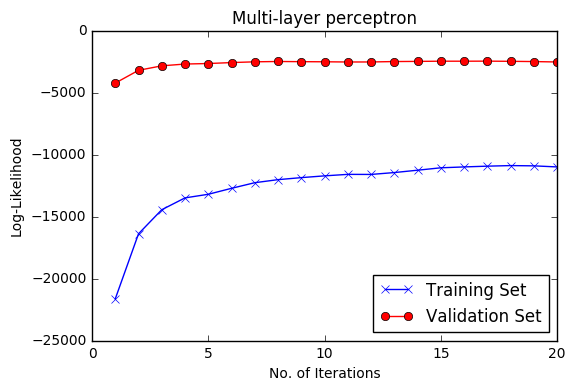

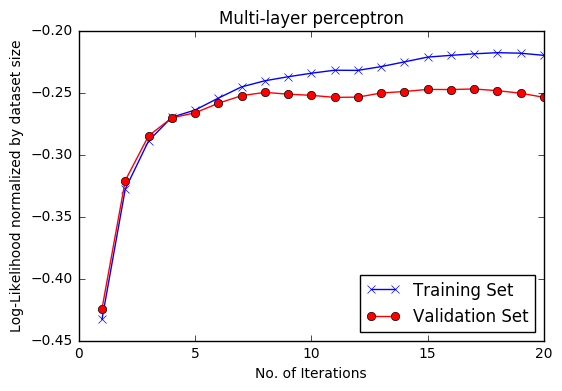

In [29]:
def dummy_encoding_vector(T):
    return np.array([dummy_encoding(t_n) for t_n in T])

fig = plt.figure()
plt.plot(range(1,max_iter+1),lp_tr,'bx-')
plt.plot(range(1,max_iter+1),lp_val,'ro-')
plt.legend(['Training Set', 'Validation Set'],loc='lower right')
plt.xlabel('No. of Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Multi-layer perceptron')
plt.plot()

# Normalize by dataset size

fig = plt.figure()
plt.plot(range(1,max_iter+1),lp_tr/x_train.shape[0],'bx-')
plt.plot(range(1,max_iter+1),lp_val/x_valid.shape[0],'ro-')
plt.legend(['Training Set', 'Validation Set'],loc='lower right')
plt.xlabel('No. of Iterations')
plt.ylabel('Log-Likelihood normalized by dataset size')
plt.title('Multi-layer perceptron')
plt.plot()



# output of hidden layer
h = sigmoid(x_test.dot(V_optima) + a_optima.T)
# output of network
q = np.exp(h.dot(W_optima) + b_optima.T)
Z = np.reshape(np.sum(q,axis=1),[q.shape[0],1])
t_n = np.array([np.argmax(q[n]/Z[n]) for n in range(q.shape[0])])
diff = t_test - t_n
misclassifications = np.count_nonzero(diff)

print 'Number of misclassifications %d' % misclassifications


### 2.3.1. Less than 250 misclassifications on the test set (10 bonus points)

You receive an additional 10 bonus points if you manage to train a model with very high accuracy: at most 2.5% misclasified digits on the test set. Note that the test set contains 10000 digits, so you model should misclassify at most 250 digits. This should be achievable with a MLP model with one hidden layer. See results of various models at : `http://yann.lecun.com/exdb/mnist/index.html`. To reach such a low accuracy, you probably need to have a very high $L$ (many hidden units), probably $L > 200$, and apply a strong Gaussian prior on the weights. In this case you are allowed to use the validation set for training.
You are allowed to add additional layers, and use convolutional networks, although that is probably not required to reach 2.5% misclassifications.